In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
glove_path = '/content/drive/MyDrive/glove.6B.100d.txt'

In [ ]:
!pip install conllu

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 7.1 MB/s eta 0:00:00


My FFNN model

In [ ]:
import warnings
from conllu import parse_incr
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from sklearn.model_selection import train_test_split

START_TOKEN = '<START>'
END_TOKEN = '<END>'


train_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in train_sentences]
train_pos_indices = [pos_tag_to_idx[tag] for sentence in train_sentences for _, _, tag in sentence]
train_input_sequences_flat = [embedding for sequence in train_input_sequences for embedding in sequence]
train_input_tensors = torch.tensor(train_input_sequences_flat, dtype=torch.float32)
train_label_tensors = torch.tensor(train_pos_indices, dtype=torch.long)

dev_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in dev_sentences]
dev_pos_indices = [pos_tag_to_idx[tag] for sentence in dev_sentences for _, _, tag in sentence]

test_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in test_sentences]
test_pos_indices = [pos_tag_to_idx[tag] for sentence in test_sentences for _, _, tag in sentence]

dev_input_sequences_flat = [embedding for sequence in dev_input_sequences for embedding in sequence]
dev_input_tensors = torch.tensor(dev_input_sequences_flat, dtype=torch.float32)
dev_label_tensors = torch.tensor(dev_pos_indices, dtype=torch.long)

test_input_sequences_flat = [embedding for sequence in test_input_sequences for embedding in sequence]
test_input_tensors = torch.tensor(test_input_sequences_flat, dtype=torch.float32)
test_label_tensors = torch.tensor(test_pos_indices, dtype=torch.long)

# pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}


def read_conllu_file(file_path):
    sentences = []
    pos_tags = set()
    with open(file_path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sentence = []
            for token in tokenlist:
                word_index = token["id"]
                lowercase_word = token["form"].lower()
                pos_tag = token["upos"]
                sentence.append((word_index, lowercase_word, pos_tag))
                pos_tags.add(pos_tag)
            sentences.append(sentence)
    return sentences, pos_tags

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

def create_input_sequence_with_embeddings(sentence, glove_embeddings, context_size):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token[1] for token in sentence] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    return input_sequences

def predict_pos_tags(sentence, model, glove_embeddings, context_size, pos_idx_to_tag):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    tokens = nltk.word_tokenize(sentence)
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token for token in tokens] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    input_tensor = torch.tensor(input_sequences, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_tags = [pos_idx_to_tag[idx.item()] for idx in predicted]
    return predicted_tags

train_file = "en_atis-ud-train.conllu"
dev_file = "en_atis-ud-dev.conllu"
test_file = "en_atis-ud-test.conllu"

train_sentences, train_pos_tags = read_conllu_file(train_file)
dev_sentences, dev_pos_tags = read_conllu_file(dev_file)
test_sentences, test_pos_tags = read_conllu_file(test_file)

all_pos_tags = train_pos_tags.union(dev_pos_tags).union(test_pos_tags)
pos_tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_pos_tags))}
pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}


glove_embeddings = load_glove_embeddings(glove_path)

class FFNN_POS_Tagging(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, activation=nn.ReLU()):
        super(FFNN_POS_Tagging, self).__init__()
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)])
        self.relu = activation
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.relu(out)
        out = self.fc2(out)
        return out

hyperparameter_configs = [
    {'hidden_size': 64, 'num_layers': 1, 'embedding_dim': 50, 'activation': nn.ReLU()},
    {'hidden_size': 128, 'num_layers': 2, 'embedding_dim': 100, 'activation': nn.ReLU()},
    {'hidden_size': 128, 'num_layers': 3, 'embedding_dim': 200, 'activation': nn.Tanh()},
    {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': nn.ReLU()}
]

train_input_tensors, val_input_tensors, train_label_tensors, val_label_tensors = train_test_split(train_input_tensors, train_label_tensors, test_size=0.1, random_state=42)

best_dev_accuracy = 0.0
best_config = None

# CONTEXT_SIZE = (2, 3)  # p = 2, s = 3
EMBEDDING_DIM = 100
NUM_POS_TAGS = len(pos_tag_to_idx)

for config in hyperparameter_configs:
    model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                              hidden_size=config['hidden_size'],
                              num_classes=NUM_POS_TAGS,
                              num_layers=config['num_layers'],
                              activation=config['activation'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    batch_size = 32
    epochs = 10
    for epoch in range(epochs):
        running_loss = 0.0
        num_batches = len(train_input_tensors) // batch_size
        for i in range(num_batches):
            batch_inputs = train_input_tensors[i * batch_size: (i + 1) * batch_size]
            batch_labels = train_label_tensors[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / num_batches

    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        dev_outputs = model(dev_input_tensors)
        _, dev_predicted = torch.max(dev_outputs, 1)
        dev_total += dev_label_tensors.size(0)
        dev_correct += (dev_predicted == dev_label_tensors).sum().item()

    dev_accuracy = dev_correct / dev_total
    print(f'Dev Set Accuracy for config: {config}, Accuracy: {dev_accuracy}')

    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_config = config

print(f'Best Hyperparameter Configuration: {best_config}, Dev Set Accuracy: {best_dev_accuracy}')


best_model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                               hidden_size=best_config['hidden_size'],
                               num_classes=NUM_POS_TAGS,
                               num_layers=best_config['num_layers'],
                               activation=best_config['activation'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

final_train_input = torch.cat([train_input_tensors, val_input_tensors], dim=0)
final_train_labels = torch.cat([train_label_tensors, val_label_tensors], dim=0)

batch_size = 32
for epoch in range(epochs):
    running_loss = 0.0
    num_batches = len(final_train_input) // batch_size
    for i in range(num_batches):
        batch_inputs = final_train_input[i * batch_size: (i + 1) * batch_size]
        batch_labels = final_train_labels[i * batch_size: (i + 1) * batch_size]

        optimizer.zero_grad()
        outputs = best_model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_batches

test_correct = 0
test_total = 0
with torch.no_grad():
    test_outputs = best_model(test_input_tensors)
    _, test_predicted = torch.max(test_outputs, 1)
    test_total += test_label_tensors.size(0)
    test_correct += (test_predicted == test_label_tensors).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Set Accuracy for Best Configuration: {test_accuracy}')



Dev Set Accuracy for config: {'hidden_size': 64, 'num_layers': 1, 'embedding_dim': 50, 'activation': ReLU()}, Accuracy: 0.9835942203491872
Dev Set Accuracy for config: {'hidden_size': 128, 'num_layers': 2, 'embedding_dim': 100, 'activation': ReLU()}, Accuracy: 0.9825406381697772
Dev Set Accuracy for config: {'hidden_size': 128, 'num_layers': 3, 'embedding_dim': 200, 'activation': Tanh()}, Accuracy: 0.9820891029500302
Dev Set Accuracy for config: {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': ReLU()}, Accuracy: 0.9817880794701986
Best Hyperparameter Configuration: {'hidden_size': 64, 'num_layers': 1, 'embedding_dim': 50, 'activation': ReLU()}, Dev Set Accuracy: 0.9835942203491872
Test Set Accuracy for Best Configuration: 0.9822188449848024


For p=s=0

In [ ]:
import warnings
from conllu import parse_incr
from collections import defaultdict

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

START_TOKEN = '<START>'
END_TOKEN = '<END>'


train_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in train_sentences]
train_pos_indices = [pos_tag_to_idx[tag] for sentence in train_sentences for _, _, tag in sentence]
train_input_sequences_flat = [embedding for sequence in train_input_sequences for embedding in sequence]
train_input_tensors = torch.tensor(train_input_sequences_flat, dtype=torch.float32)
train_label_tensors = torch.tensor(train_pos_indices, dtype=torch.long)

dev_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in dev_sentences]
dev_pos_indices = [pos_tag_to_idx[tag] for sentence in dev_sentences for _, _, tag in sentence]

test_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in test_sentences]
test_pos_indices = [pos_tag_to_idx[tag] for sentence in test_sentences for _, _, tag in sentence]

dev_input_sequences_flat = [embedding for sequence in dev_input_sequences for embedding in sequence]
dev_input_tensors = torch.tensor(dev_input_sequences_flat, dtype=torch.float32)
dev_label_tensors = torch.tensor(dev_pos_indices, dtype=torch.long)

test_input_sequences_flat = [embedding for sequence in test_input_sequences for embedding in sequence]
test_input_tensors = torch.tensor(test_input_sequences_flat, dtype=torch.float32)
test_label_tensors = torch.tensor(test_pos_indices, dtype=torch.long)

# pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}



import warnings
from conllu import parse_incr
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from sklearn.model_selection import train_test_split

def read_conllu_file(file_path):
    sentences = []
    pos_tags = set()
    with open(file_path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sentence = []
            for token in tokenlist:
                word_index = token["id"]
                lowercase_word = token["form"].lower()
                pos_tag = token["upos"]
                sentence.append((word_index, lowercase_word, pos_tag))
                pos_tags.add(pos_tag)
            sentences.append(sentence)
    return sentences, pos_tags

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

def create_input_sequence_with_embeddings(sentence, glove_embeddings, context_size):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token[1] for token in sentence] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    return input_sequences

def predict_pos_tags(sentence, model, glove_embeddings, context_size, pos_idx_to_tag):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    tokens = nltk.word_tokenize(sentence)
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token for token in tokens] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    input_tensor = torch.tensor(input_sequences, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_tags = [pos_idx_to_tag[idx.item()] for idx in predicted]
    return predicted_tags

train_file = "en_atis-ud-train.conllu"
dev_file = "en_atis-ud-dev.conllu"
test_file = "en_atis-ud-test.conllu"

train_sentences, train_pos_tags = read_conllu_file(train_file)
dev_sentences, dev_pos_tags = read_conllu_file(dev_file)
test_sentences, test_pos_tags = read_conllu_file(test_file)

all_pos_tags = train_pos_tags.union(dev_pos_tags).union(test_pos_tags)
pos_tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_pos_tags))}
pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}


glove_embeddings = load_glove_embeddings(glove_path)

class FFNN_POS_Tagging(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, activation=nn.ReLU()):
        super(FFNN_POS_Tagging, self).__init__()
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)])
        self.relu = activation
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.relu(out)
        out = self.fc2(out)
        return out

hyperparameter_configs = [
    {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': nn.ReLU()}
]

train_input_tensors, val_input_tensors, train_label_tensors, val_label_tensors = train_test_split(train_input_tensors, train_label_tensors, test_size=0.1, random_state=42)

best_dev_accuracy = 0.0
best_config = None

CONTEXT_SIZE = (0,0)
EMBEDDING_DIM = 100
NUM_POS_TAGS = len(pos_tag_to_idx)

for config in hyperparameter_configs:
    model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                              hidden_size=config['hidden_size'],
                              num_classes=NUM_POS_TAGS,
                              num_layers=config['num_layers'],
                              activation=config['activation'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    batch_size = 32
    epochs = 10
    for epoch in range(epochs):
        running_loss = 0.0
        num_batches = len(train_input_tensors) // batch_size
        for i in range(num_batches):
            batch_inputs = train_input_tensors[i * batch_size: (i + 1) * batch_size]
            batch_labels = train_label_tensors[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / num_batches

    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        dev_outputs = model(dev_input_tensors)
        _, dev_predicted = torch.max(dev_outputs, 1)
        dev_total += dev_label_tensors.size(0)
        dev_correct += (dev_predicted == dev_label_tensors).sum().item()

    dev_accuracy = dev_correct / dev_total
    print(f'Dev Set Accuracy for config: {config}, Accuracy: {dev_accuracy}')

    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_config = config

print(f'Best Hyperparameter Configuration: {best_config}, Dev Set Accuracy: {best_dev_accuracy}')


best_model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                               hidden_size=best_config['hidden_size'],
                               num_classes=NUM_POS_TAGS,
                               num_layers=best_config['num_layers'],
                               activation=best_config['activation'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

final_train_input = torch.cat([train_input_tensors, val_input_tensors], dim=0)
final_train_labels = torch.cat([train_label_tensors, val_label_tensors], dim=0)

batch_size = 32
for epoch in range(epochs):
    running_loss = 0.0
    num_batches = len(final_train_input) // batch_size
    for i in range(num_batches):
        batch_inputs = final_train_input[i * batch_size: (i + 1) * batch_size]
        batch_labels = final_train_labels[i * batch_size: (i + 1) * batch_size]

        optimizer.zero_grad()
        outputs = best_model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_batches

test_correct = 0
test_total = 0
with torch.no_grad():
    test_outputs = best_model(test_input_tensors)
    _, test_predicted = torch.max(test_outputs, 1)
    test_total += test_label_tensors.size(0)
    test_correct += (test_predicted == test_label_tensors).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Set Accuracy for Best Configuration: {test_accuracy}')



Dev Set Accuracy for config: {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': ReLU()}, Accuracy: 0.9611679711017459
Best Hyperparameter Configuration: {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': ReLU()}, Dev Set Accuracy: 0.9611679711017459
Test Set Accuracy for Best Configuration: 0.9629179331306991


for p=s=1

In [24]:
import warnings
from conllu import parse_incr
from collections import defaultdict

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

START_TOKEN = '<START>'
END_TOKEN = '<END>'


train_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in train_sentences]
train_pos_indices = [pos_tag_to_idx[tag] for sentence in train_sentences for _, _, tag in sentence]
train_input_sequences_flat = [embedding for sequence in train_input_sequences for embedding in sequence]
train_input_tensors = torch.tensor(train_input_sequences_flat, dtype=torch.float32)
train_label_tensors = torch.tensor(train_pos_indices, dtype=torch.long)

dev_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in dev_sentences]
dev_pos_indices = [pos_tag_to_idx[tag] for sentence in dev_sentences for _, _, tag in sentence]

test_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in test_sentences]
test_pos_indices = [pos_tag_to_idx[tag] for sentence in test_sentences for _, _, tag in sentence]

dev_input_sequences_flat = [embedding for sequence in dev_input_sequences for embedding in sequence]
dev_input_tensors = torch.tensor(dev_input_sequences_flat, dtype=torch.float32)
dev_label_tensors = torch.tensor(dev_pos_indices, dtype=torch.long)

test_input_sequences_flat = [embedding for sequence in test_input_sequences for embedding in sequence]
test_input_tensors = torch.tensor(test_input_sequences_flat, dtype=torch.float32)
test_label_tensors = torch.tensor(test_pos_indices, dtype=torch.long)

# pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}



import warnings
from conllu import parse_incr
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from sklearn.model_selection import train_test_split

def read_conllu_file(file_path):
    sentences = []
    pos_tags = set()
    with open(file_path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sentence = []
            for token in tokenlist:
                word_index = token["id"]
                lowercase_word = token["form"].lower()
                pos_tag = token["upos"]
                sentence.append((word_index, lowercase_word, pos_tag))
                pos_tags.add(pos_tag)
            sentences.append(sentence)
    return sentences, pos_tags

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

def create_input_sequence_with_embeddings(sentence, glove_embeddings, context_size):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token[1] for token in sentence] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    return input_sequences

def predict_pos_tags(sentence, model, glove_embeddings, context_size, pos_idx_to_tag):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    tokens = nltk.word_tokenize(sentence)
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token for token in tokens] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    input_tensor = torch.tensor(input_sequences, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_tags = [pos_idx_to_tag[idx.item()] for idx in predicted]
    return predicted_tags

train_file = "en_atis-ud-train.conllu"
dev_file = "en_atis-ud-dev.conllu"
test_file = "en_atis-ud-test.conllu"

train_sentences, train_pos_tags = read_conllu_file(train_file)
dev_sentences, dev_pos_tags = read_conllu_file(dev_file)
test_sentences, test_pos_tags = read_conllu_file(test_file)

all_pos_tags = train_pos_tags.union(dev_pos_tags).union(test_pos_tags)
pos_tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_pos_tags))}
pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}


glove_embeddings = load_glove_embeddings(glove_path)

class FFNN_POS_Tagging(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, activation=nn.ReLU()):
        super(FFNN_POS_Tagging, self).__init__()
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)])
        self.relu = activation
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.relu(out)
        out = self.fc2(out)
        return out

hyperparameter_configs = [
    {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': nn.ReLU()}
]

train_input_tensors, val_input_tensors, train_label_tensors, val_label_tensors = train_test_split(train_input_tensors, train_label_tensors, test_size=0.1, random_state=42)

best_dev_accuracy = 0.0
best_config = None

CONTEXT_SIZE = (1,1)
EMBEDDING_DIM = 100
NUM_POS_TAGS = len(pos_tag_to_idx)

for config in hyperparameter_configs:
    model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                              hidden_size=config['hidden_size'],
                              num_classes=NUM_POS_TAGS,
                              num_layers=config['num_layers'],
                              activation=config['activation'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    batch_size = 32
    epochs = 10
    for epoch in range(epochs):
        running_loss = 0.0
        num_batches = len(train_input_tensors) // batch_size
        for i in range(num_batches):
            batch_inputs = train_input_tensors[i * batch_size: (i + 1) * batch_size]
            batch_labels = train_label_tensors[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / num_batches

    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        dev_outputs = model(dev_input_tensors)
        _, dev_predicted = torch.max(dev_outputs, 1)
        dev_total += dev_label_tensors.size(0)
        dev_correct += (dev_predicted == dev_label_tensors).sum().item()

    dev_accuracy = dev_correct / dev_total
    print(f'Dev Set Accuracy for config: {config}, Accuracy: {dev_accuracy}')

    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_config = config

print(f'Best Hyperparameter Configuration: {best_config}, Dev Set Accuracy: {best_dev_accuracy}')


best_model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                               hidden_size=best_config['hidden_size'],
                               num_classes=NUM_POS_TAGS,
                               num_layers=best_config['num_layers'],
                               activation=best_config['activation'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

final_train_input = torch.cat([train_input_tensors, val_input_tensors], dim=0)
final_train_labels = torch.cat([train_label_tensors, val_label_tensors], dim=0)

batch_size = 32
for epoch in range(epochs):
    running_loss = 0.0
    num_batches = len(final_train_input) // batch_size
    for i in range(num_batches):
        batch_inputs = final_train_input[i * batch_size: (i + 1) * batch_size]
        batch_labels = final_train_labels[i * batch_size: (i + 1) * batch_size]

        optimizer.zero_grad()
        outputs = best_model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_batches

test_correct = 0
test_total = 0
with torch.no_grad():
    test_outputs = best_model(test_input_tensors)
    _, test_predicted = torch.max(test_outputs, 1)
    test_total += test_label_tensors.size(0)
    test_correct += (test_predicted == test_label_tensors).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Set Accuracy for Best Configuration: {test_accuracy}')



Dev Set Accuracy for config: {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': ReLU()}, Accuracy: 0.9817880794701986
Best Hyperparameter Configuration: {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': ReLU()}, Dev Set Accuracy: 0.9817880794701986
Test Set Accuracy for Best Configuration: 0.9837386018237082


For p=s=3

In [27]:
import warnings
from conllu import parse_incr
from collections import defaultdict

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

START_TOKEN = '<START>'
END_TOKEN = '<END>'


train_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in train_sentences]
train_pos_indices = [pos_tag_to_idx[tag] for sentence in train_sentences for _, _, tag in sentence]
train_input_sequences_flat = [embedding for sequence in train_input_sequences for embedding in sequence]
train_input_tensors = torch.tensor(train_input_sequences_flat, dtype=torch.float32)
train_label_tensors = torch.tensor(train_pos_indices, dtype=torch.long)

dev_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in dev_sentences]
dev_pos_indices = [pos_tag_to_idx[tag] for sentence in dev_sentences for _, _, tag in sentence]

test_input_sequences = [create_input_sequence_with_embeddings(sentence, glove_embeddings, CONTEXT_SIZE) for sentence in test_sentences]
test_pos_indices = [pos_tag_to_idx[tag] for sentence in test_sentences for _, _, tag in sentence]

dev_input_sequences_flat = [embedding for sequence in dev_input_sequences for embedding in sequence]
dev_input_tensors = torch.tensor(dev_input_sequences_flat, dtype=torch.float32)
dev_label_tensors = torch.tensor(dev_pos_indices, dtype=torch.long)

test_input_sequences_flat = [embedding for sequence in test_input_sequences for embedding in sequence]
test_input_tensors = torch.tensor(test_input_sequences_flat, dtype=torch.float32)
test_label_tensors = torch.tensor(test_pos_indices, dtype=torch.long)

# pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}



import warnings
from conllu import parse_incr
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from sklearn.model_selection import train_test_split

def read_conllu_file(file_path):
    sentences = []
    pos_tags = set()
    with open(file_path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sentence = []
            for token in tokenlist:
                word_index = token["id"]
                lowercase_word = token["form"].lower()
                pos_tag = token["upos"]
                sentence.append((word_index, lowercase_word, pos_tag))
                pos_tags.add(pos_tag)
            sentences.append(sentence)
    return sentences, pos_tags

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

def create_input_sequence_with_embeddings(sentence, glove_embeddings, context_size):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token[1] for token in sentence] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    return input_sequences

def predict_pos_tags(sentence, model, glove_embeddings, context_size, pos_idx_to_tag):
    START_TOKEN = '<START>'
    END_TOKEN = '<END>'
    tokens = nltk.word_tokenize(sentence)
    sentence_with_tokens = [START_TOKEN] * context_size[0] + [token for token in tokens] + [END_TOKEN] * context_size[1]
    input_sequences = []
    for i in range(context_size[0], len(sentence_with_tokens) - context_size[1]):
        context_words = sentence_with_tokens[i - context_size[0]: i + context_size[1] + 1]
        context_embeddings = [glove_embeddings[word] if word in glove_embeddings else np.zeros(EMBEDDING_DIM) for word in context_words]
        input_sequence = np.concatenate(context_embeddings)
        input_sequences.append(input_sequence)
    input_tensor = torch.tensor(input_sequences, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_tags = [pos_idx_to_tag[idx.item()] for idx in predicted]
    return predicted_tags

train_file = "en_atis-ud-train.conllu"
dev_file = "en_atis-ud-dev.conllu"
test_file = "en_atis-ud-test.conllu"

train_sentences, train_pos_tags = read_conllu_file(train_file)
dev_sentences, dev_pos_tags = read_conllu_file(dev_file)
test_sentences, test_pos_tags = read_conllu_file(test_file)

all_pos_tags = train_pos_tags.union(dev_pos_tags).union(test_pos_tags)
pos_tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_pos_tags))}
pos_idx_to_tag = {idx: tag for tag, idx in pos_tag_to_idx.items()}


glove_embeddings = load_glove_embeddings(glove_path)

class FFNN_POS_Tagging(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, activation=nn.ReLU()):
        super(FFNN_POS_Tagging, self).__init__()
        self.num_layers = num_layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)])
        self.relu = activation
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.relu(out)
        out = self.fc2(out)
        return out

hyperparameter_configs = [
    {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': nn.ReLU()}
]

train_input_tensors, val_input_tensors, train_label_tensors, val_label_tensors = train_test_split(train_input_tensors, train_label_tensors, test_size=0.1, random_state=42)

best_dev_accuracy = 0.0
best_config = None

CONTEXT_SIZE = (3,3)
EMBEDDING_DIM = 100
NUM_POS_TAGS = len(pos_tag_to_idx)

for config in hyperparameter_configs:
    model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                              hidden_size=config['hidden_size'],
                              num_classes=NUM_POS_TAGS,
                              num_layers=config['num_layers'],
                              activation=config['activation'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    batch_size = 32
    epochs = 10
    for epoch in range(epochs):
        running_loss = 0.0
        num_batches = len(train_input_tensors) // batch_size
        for i in range(num_batches):
            batch_inputs = train_input_tensors[i * batch_size: (i + 1) * batch_size]
            batch_labels = train_label_tensors[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / num_batches

    dev_correct = 0
    dev_total = 0
    with torch.no_grad():
        dev_outputs = model(dev_input_tensors)
        _, dev_predicted = torch.max(dev_outputs, 1)
        dev_total += dev_label_tensors.size(0)
        dev_correct += (dev_predicted == dev_label_tensors).sum().item()

    dev_accuracy = dev_correct / dev_total
    print(f'Dev Set Accuracy for config: {config}, Accuracy: {dev_accuracy}')

    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_config = config

print(f'Best Hyperparameter Configuration: {best_config}, Dev Set Accuracy: {best_dev_accuracy}')


best_model = FFNN_POS_Tagging(input_size= EMBEDDING_DIM * (sum(CONTEXT_SIZE)+1),
                               hidden_size=best_config['hidden_size'],
                               num_classes=NUM_POS_TAGS,
                               num_layers=best_config['num_layers'],
                               activation=best_config['activation'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

final_train_input = torch.cat([train_input_tensors, val_input_tensors], dim=0)
final_train_labels = torch.cat([train_label_tensors, val_label_tensors], dim=0)

batch_size = 32
for epoch in range(epochs):
    running_loss = 0.0
    num_batches = len(final_train_input) // batch_size
    for i in range(num_batches):
        batch_inputs = final_train_input[i * batch_size: (i + 1) * batch_size]
        batch_labels = final_train_labels[i * batch_size: (i + 1) * batch_size]

        optimizer.zero_grad()
        outputs = best_model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_batches

test_correct = 0
test_total = 0
with torch.no_grad():
    test_outputs = best_model(test_input_tensors)
    _, test_predicted = torch.max(test_outputs, 1)
    test_total += test_label_tensors.size(0)
    test_correct += (test_predicted == test_label_tensors).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Set Accuracy for Best Configuration: {test_accuracy}')



Dev Set Accuracy for config: {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': ReLU()}, Accuracy: 0.9754665863937387
Best Hyperparameter Configuration: {'hidden_size': 256, 'num_layers': 4, 'embedding_dim': 200, 'activation': ReLU()}, Dev Set Accuracy: 0.9754665863937387
Test Set Accuracy for Best Configuration: 0.9803951367781155


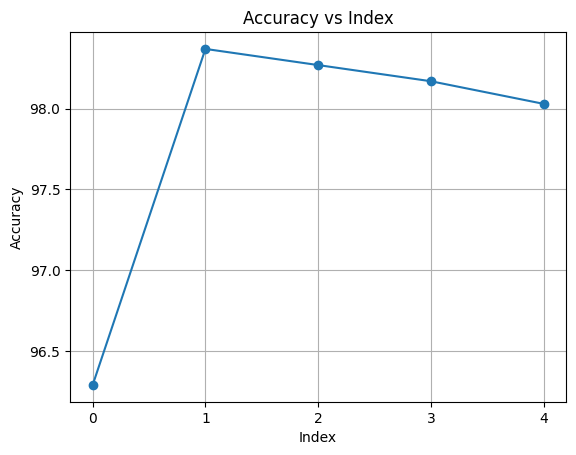

In [28]:
import matplotlib.pyplot as plt

accuracies = [96.29, 98.37, 98.27, 98.17, 98.03]
indices = list(range(len(accuracies)))

plt.plot(indices, accuracies, marker='o')
plt.title('Accuracy vs Index')
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.xticks(indices)
plt.grid(True)
plt.show()


In [34]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Function to evaluate model and generate metrics
def evaluate_model(model, input_tensors, label_tensors):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(input_tensors)
        _, predicted = torch.max(outputs, 1)

        # Convert tensor predictions and labels to numpy arrays
        predicted = predicted.cpu().numpy()
        labels = label_tensors.cpu().numpy()

        # Compute evaluation metrics
        accuracy = accuracy_score(labels, predicted)
        recall_micro = recall_score(labels, predicted, average='micro')
        recall_macro = recall_score(labels, predicted, average='macro')
        f1_micro = f1_score(labels, predicted, average='micro')
        f1_macro = f1_score(labels, predicted, average='macro')

        # Generate confusion matrix
        cm = confusion_matrix(labels, predicted)

    return accuracy, recall_micro, recall_macro, f1_micro, f1_macro, cm

# Evaluate model on dev set
dev_accuracy, dev_recall_micro, dev_recall_macro, dev_f1_micro, dev_f1_macro, dev_cm = evaluate_model(best_model, dev_input_tensors, dev_label_tensors)

print("Dev Set Evaluation:")
print(f"Accuracy: {dev_accuracy}")
print(f"Recall (Micro): {dev_recall_micro}")
print(f"Recall (Macro): {dev_recall_macro}")
print(f"F1-Score (Micro): {dev_f1_micro}")
print(f"F1-Score (Macro): {dev_f1_macro}")
print("Confusion Matrix:")
print(dev_cm)

# Evaluate model on test set
test_accuracy, test_recall_micro, test_recall_macro, test_f1_micro, test_f1_macro, test_cm = evaluate_model(best_model, test_input_tensors, test_label_tensors)

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy}")
print(f"Recall (Micro): {test_recall_micro}")
print(f"Recall (Macro): {test_recall_macro}")
print(f"F1-Score (Micro): {test_f1_micro}")
print(f"F1-Score (Macro): {test_f1_macro}")
print("Confusion Matrix:")
print(test_cm)


Dev Set Evaluation:
Accuracy: 0.9739614689945816
Recall (Micro): 0.9739614689945816
Recall (Macro): 0.8893533540178932
F1-Score (Micro): 0.9739614689945816
F1-Score (Macro): 0.8815304661180864
Confusion Matrix:
[[ 186    1   23    1    0    4    0   10    0    0    0    2    0    0]
 [   0 1393    2    0    0    4    0    1    0    7    8    0    0    0]
 [   2    0   50    1    0    0    0    3    1    0    0    1    0    1]
 [   0    0    1  254    0    0    0    0    0    0    0    0    0   11]
 [   0    0    0    0  107    0    0    0    0    0    0    0    0    0]
 [   0   14    0    0    0  542    0    0    0    0   12    0    0    0]
 [   0    0    0    0    0    0   35    0    0    0    0    0    0    0]
 [   0    0    2    0    0    0    0 1128    0    0    0    6    0    7]
 [   0    0    1    0    0    0    0    1  129    0    0    0    0    0]
 [   0    1    0    0    1    0    0    0    0   71    0    0    0    0]
 [   0    0    2    0    0    1    0    0    0    0  411   